# ⚛️ ✈️QuantumFlightOnTime — Versão Quântica do Sistema de Predição de Atrasos de Voos

Este notebook representa a versão quântica experimental do sistema ✈️ FlightOnTime, um sistema de Machine Learning desenvolvido para prever atrasos de voos.

O objetivo desta versão é **avaliar o uso de Machine Learning Quântico (Quantum Machine Learning – QML)**
como alternativa ou complemento aos modelos clássicos já utilizados no FlightOnTime,
comparando desempenho, limitações e viabilidade prática.

O modelo é executado em ambiente de simulação clássica, tendo como objetivo explorar e demonstrar o paradigma de Machine Learning Quântico, e não superar o desempenho dos modelos clássicos.

A abordagem quântica é implementada por meio de **classificadores quânticos variacionais**,
utilizando a biblioteca **PennyLane**, mantendo **consistência metodológica** com a versão clássica
(métrica ROC-AUC, divisão treino/teste e contexto de negócio).




## 🎯 Objetivo

O objetivo principal deste notebook é:

> **Construir e avaliar um modelo de Machine Learning Quântico para a previsão de atrasos de voos.**

Objetivos específicos:
- Implementar um **classificador quântico variacional: Variational Quantum Classifiers (VQC)**
- Avaliar o desempenho utilizando **ROC-AUC**
- Analisar limitações computacionais e escalabilidade do modelo quântico

## ❗ Contexto do Problema (✈️FlightOnTime)

- **Problema**: Prever se um voo atrasará ≥ 15 minutos
- **Tipo**: Classificação binária
- **Métrica principal**: ROC-AUC
- **Perspectiva**: Decisão operacional pré-voo
- **Modelo clássico de referência**: ✈️ [FlightOnTime](https://github.com/FlightOnTime/flight-delay-ds)

## 1️⃣ 📦 Instalação e Importação de Bibliotecas

Bibliotecas clássicas e quânticas utilizadas para construção, treinamento e avaliação
do modelo quântico.


In [ ]:
# Instalação de Bibliotecas
!pip install pennylane
print("✅ Biblioteca instalada com sucesso!")

✅ Biblioteca instalada com sucesso!


In [ ]:
# IMPORTAÇÃO DE BIBLIOTECAS
# ===================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pennylane as qml
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pennylane import numpy as np
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    average_precision_score
)

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


## 2️⃣ 📂 Carregamento dos Dados

Os dados utilizados neste notebook derivam do projeto FlightOnTime
e já passaram por etapas prévias de limpeza e engenharia de features.


In [ ]:
DATA_PATH = Path("data") / "/content/bts_tratado_flightontime.csv"

df = pd.read_csv(DATA_PATH)
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset não encontrado em {DATA_PATH}")
print("✅ Dados carregados com sucesso!")
df.head()

✅ Dados carregados com sucesso!


,Year,Month,DayOfMonth,DayOfWeek,Airline,Origin,Dest,CRSDepTime,Distance,FlightDate,ArrDelay15
0,2023,1,1,7,WN,AUS,HOU,830,148.0,2023-01-01,0
1,2023,1,1,7,UA,IAH,DEN,1237,862.0,2023-01-01,0
2,2023,1,1,7,UA,IAH,DEN,1438,862.0,2023-01-01,0
3,2023,1,1,7,UA,IAH,DEN,1622,862.0,2023-01-01,0
4,2023,1,1,7,UA,IAH,DEN,1850,862.0,2023-01-01,1


## 3️⃣🧩 Seleção de Features

Devido às limitações atuais de **Machine Learning Quântico**, principalmente relacionadas
ao número de qubits e ao custo computacional da simulação quântica, foi necessário
selecionar um subconjunto reduzido de features.

### Features Selecionadas

As seguintes variáveis foram utilizadas como entrada do modelo quântico:

- `Month`
- `DayOfWeek`
- `CRSDepTime`
- `Distance`

### Justificativa da Seleção

Essas features foram escolhidas porque:
- São **numéricas** (evitam overhead de encoding categórico)
- Possuem **relação direta com atrasos de voos**
- Reduzem a necessidade de qubits (1 qubit ≈ 1 feature)
- Permitem viabilizar a simulação quântica em CPU

### Por que poucas features?

Modelos quânticos atuais apresentam limitações práticas:
- O número de qubits cresce linearmente com o número de features
- O custo computacional cresce exponencialmente
- Simulações com muitos qubits tornam-se inviáveis

Portanto, optou-se por um **conjunto reduzido e informativo de variáveis**,
priorizando viabilidade experimental em detrimento de complexidade.

In [ ]:
# SELEÇÃO DE FEATURES
FEATURES = ["Month", "DayOfWeek", "CRSDepTime", "Distance"]
TARGET = "ArrDelay15"
X = df[FEATURES]
y = df[TARGET]
print("✅ Features selecionadas com sucesso!")

✅ Features selecionadas com sucesso!


## 4️⃣ 🔄 Pré-processamento dos Dados

Nesta etapa realizamos:
- Padronização das features
- Separação em conjuntos de treino e teste
- Preparação dos dados para entrada no circuito quântico
- Seleção de Variáveis Numéricas

In [ ]:

# Seleção de Variáveis Numéricas| Modelos quânticos variacionais exigem inputs numéricos
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
X = X[num_cols]

# Remover linhas com valores NaN na variável alvo
nan_indices = y.index[y.isnull()]
X = X.drop(nan_indices)
y = y.drop(nan_indices)

# Normalização | a normalização para o intervalo [-1, 1] é necessária para garantir estabilidade numérica
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

#Separação em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("✅ Dados pré-processados com sucesso!")

✅ Dados pré-processados com sucesso!


## 5️⃣ ⚙️ Configuração do Modelo Quântico

Definição dos hiperparâmetros do classificador quântico:
- Número de qubits (features selecionadas)
- Profundidade do circuito
- Estratégia de embedding

>O número de qubits foi limitado para viabilidade computacional.

In [ ]:
n_qubits = X_train.shape[1]
n_layers = 3

dev = qml.device("default.qubit", wires=n_qubits)
print("✅ Modelo quântico configurado com sucesso!")

✅ Modelo quântico configurado com sucesso!


## 6️ 🔬 Subamostra para Treino Quântico

Devido ao alto custo computacional da simulação quântica,
foi utilizada uma **subamostra do conjunto de treino**.

Essa estratégia permite:
- Reduzir o tempo de treinamento
- Tornar o experimento viável em ambiente clássico (CPU)
- Avaliar o comportamento inicial do modelo quântico

In [ ]:
N_SAMPLES = 300
X_train = X_train[:N_SAMPLES]
y_train = y_train[:N_SAMPLES]
print(f"✅ Subamostra de treino criada com sucesso! Tamanho: {len(X_train)}")

✅ Subamostra de treino criada com sucesso! Tamanho: 300


## 7️⃣⚙️ Dispositivo Quântico

Definição do dispositivo quântico utilizado na simulação.
Neste projeto, utiliza-se o simulador `default.qubit`,
executado em CPU.

In [ ]:
#Dispositivo Quântico
dev = qml.device("default.qubit", wires=n_qubits)
print("✅ Dispositivo quântico configurado com sucesso!")

✅ Dispositivo quântico configurado com sucesso!


## 8️⃣ 🧠 Definição do Circuito Quântico

O modelo utilizado pertence à classe dos [Variational Quantum Classifiers (VQC)](https://pennylane.ai/qml/demos/tutorial_variational_classifier/?utm_source=chatgpt.com), a arquitetura adotada foi adaptada para dados tabulares reais e não corresponde exatamente à implementação apresentada no tutorial de referência, diferenciando-se na estratégia de codificação, no domínio do problema e na configuração do circuito quântico.

### 🔹Exemplo conceitual de um VQC
- Considere um vetor de entrada clássico:

$$
\mathbf{x} = (x_1, x_2, \dots, x_d)
$$<br>
#### Codificação dos dados (Angle Encoding)

- Cada variável de entrada é codificada por meio de uma rotação quântica do tipo:

$$
R_Y(x_i) = e^{-i \frac{x_i}{2} Y}
$$

<br>

- O operador de codificação aplicado ao circuito pode ser representado como:

<br>

$$
U_{\text{enc}}(\mathbf{x}) = \prod_{i=1}^{d} R_Y(x_i)
$$

---
### 🔹Circuito Variacional

Após a codificação, aplica-se um circuito quântico parametrizado, definido por:

$$
U(\boldsymbol{\theta}) = \prod_{l=1}^{L} U_{\text{var}}^{(l)}(\boldsymbol{\theta}_l)
$$
<br>
onde cada camada variacional contém rotações quânticas e portas de emaranhamento.

---
<br>

#### 🔹Saída do classificador

A saída do classificador quântico variacional é obtida a partir do valor esperado
de um observável quântico:

$$
\hat{y}(\mathbf{x}) =
\langle 0 |
U^\dagger(\boldsymbol{\theta})
U^\dagger_{\text{enc}}(\mathbf{x})
\; Z_0 \;
U_{\text{enc}}(\mathbf{x})
U(\boldsymbol{\theta})
| 0 \rangle
$$

onde \(Z_0\) representa o operador de Pauli-Z aplicado ao qubit de leitura.

📌 No código:


```
qml.expval(qml.PauliZ(0))

```

In [ ]:
@qml.qnode(dev)
def quantum_classifier(weights, x):
    """
    Variational Quantum Classifier (VQC)
    - Angle Embedding
    - Camadas variacionais com emaranhamento
    - Medição no qubit 0
    """

    # 1️⃣ Encoding dos dados (feito UMA ÚNICA VEZ)
    qml.AngleEmbedding(
        features=x,
        wires=range(n_qubits),
        rotation='Y'
    )

    # 2️⃣ Camadas variacionais
    qml.BasicEntanglerLayers(
        weights=weights,
        wires=range(n_qubits)
    )

    # 3️⃣ Medição
    return qml.expval(qml.PauliZ(0))
print("✅ Circuito quântico definido com sucesso!")

✅ Circuito quântico definido com sucesso!


## 9️⃣ 📉 Classificador e Função de Perda

A função de perda é definida com base na diferença entre
os rótulos reais e a saída probabilística do circuito quântico.

In [ ]:
# Cálculo dos pesos das classes
y_train_np = y_train.to_numpy()

n_pos = np.sum(y_train_np == 1)
n_neg = np.sum(y_train_np == 0)

weight_pos = n_neg / (n_pos + n_neg)
weight_neg = n_pos / (n_pos + n_neg)

print(f"Peso classe 0 (on-time): {weight_neg:.3f}")
print(f"Peso classe 1 (delay): {weight_pos:.3f}")

# Classificador + Loss (MSE balanceado)
def loss(weights, X, y):
    preds = [(quantum_classifier(weights, x) + 1) / 2 for x in X]

    y_np = y.to_numpy().astype(float)
    preds_np = np.array(preds).astype(float)

    # Calcula a perda com MSE, ajustando pesos para as classes positiva e negativa.
    sample_weights_array = np.array([weight_pos if val == 1 else weight_neg for val in y_np])

    return np.mean(sample_weights_array * (y_np - preds_np) ** 2)


#Inicialização dos Pesos
np.random.seed(42)

weights = np.random.randn(
    n_layers, n_qubits,
    requires_grad=True
) * 0.01
#PREPARAÇÃO (ANTES DO LOOP) | Accuracy simples (binária, threshold = 0.5)
def accuracy_score_quantum(y_true, y_pred_prob, threshold=0.5):
    y_pred_bin = (y_pred_prob >= threshold).astype(int)
    return (y_pred_bin == y_true).mean()

#Otimizador
opt = qml.AdamOptimizer(stepsize=0.03)
print("✅ Classificador e função de perda definidos com sucesso!")

Peso classe 0 (on-time): 0.193
Peso classe 1 (delay): 0.807
✅ Classificador e função de perda definidos com sucesso!


## 🔟  🦾 Treinamento do Modelo Quântico

O treinamento ajusta os parâmetros do circuito quântico por meio
de um otimizador clássico, minimizando a função de custo definida.

🔁 Iniciando treinamento do modelo quântico...

Epoch 01/30 | Train Loss: 0.12798 | Val Loss: 0.13010 | Accuracy: 0.205
───────────────────────────────────────────────────────
Epoch 02/30 | Train Loss: 0.12686 | Val Loss: 0.12886 | Accuracy: 0.205
───────────────────────────────────────────────────────
Epoch 03/30 | Train Loss: 0.12503 | Val Loss: 0.12684 | Accuracy: 0.205
───────────────────────────────────────────────────────
Epoch 04/30 | Train Loss: 0.12251 | Val Loss: 0.12405 | Accuracy: 0.205
───────────────────────────────────────────────────────
Epoch 05/30 | Train Loss: 0.11936 | Val Loss: 0.12056 | Accuracy: 0.205
───────────────────────────────────────────────────────
Epoch 06/30 | Train Loss: 0.11564 | Val Loss: 0.11645 | Accuracy: 0.205
───────────────────────────────────────────────────────
Epoch 07/30 | Train Loss: 0.11147 | Val Loss: 0.11184 | Accuracy: 0.205
───────────────────────────────────────────────────────
Epoch 08/30 | Train Loss: 0.10698 | Val Loss: 0.10688 | A

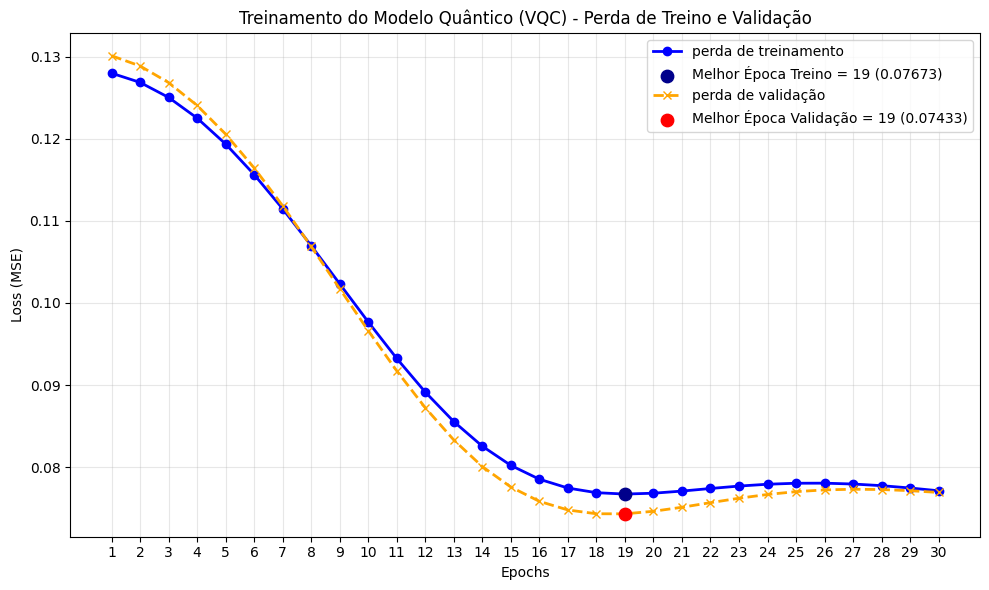

✅ Gráfico de perda do treinamento e validação combinado criado com sucesso!


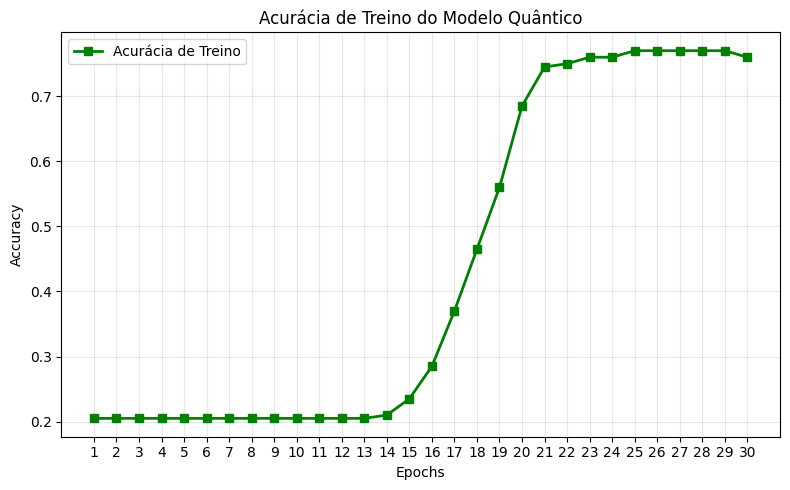

✅ Gráfico de acurácia de treino criado com sucesso!


In [ ]:
epochs = 30
train_loss_history = []
val_loss_history = [] 
acc_history = []

# Define X_test_small e y_test_small para o cálculo da perda de validação
X_test_small = X_test[:N_SAMPLES]
y_test_small = y_test[:N_SAMPLES]

print("🔁 Iniciando treinamento do modelo quântico...\n")

for epoch in range(epochs):
    # Passo do otimizador
    weights = opt.step(
        lambda w: loss(w, X_train, y_train),
        weights
    )

    # Loss de treinamento atual
    current_train_loss = loss(weights, X_train, y_train)
    train_loss_history.append(current_train_loss)

    # Loss de validação atual
    current_val_loss = loss(weights, X_test_small, y_test_small)
    val_loss_history.append(current_val_loss)

    # Predições no treino (subamostra para performance)
    MAX_ACC_SAMPLES = 200
    X_acc = X_train[:MAX_ACC_SAMPLES]
    y_acc = y_train.iloc[:MAX_ACC_SAMPLES].to_numpy()

    y_pred_train = np.array(
        [(quantum_classifier(weights, x) + 1) / 2 for x in X_acc],
        dtype=float
    )

    acc = accuracy_score_quantum(
    y_acc,
    y_pred_train,
    threshold=0.5
    )
    acc_history.append(acc)

    # Saída visual (menos casas decimais no Accuracy)
    print(
        f"Epoch {epoch+1:02d}/{epochs} | "
        f"Train Loss: {current_train_loss:.5f} | "
        f"Val Loss: {current_val_loss:.5f} | " # Display validation loss
        f"Accuracy: {acc:.3f}"
    )
    print("─" * 55)

print("✅ Treinamento Concluído!")

#========VISUALIZAÇÃO DO TREINAMENTO==========

best_epoch_train = int(np.argmin(train_loss_history)) + 1
best_train_loss = min(train_loss_history)

best_epoch_val = int(np.argmin(val_loss_history)) + 1
best_val_loss = min(val_loss_history)

# Plot único: Perda de Treinamento e Validação
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, epochs + 1),
    train_loss_history,
    marker="o",
    linewidth=2,
    label="perda de treinamento",
    color='blue'
)
plt.scatter(
    best_epoch_train,
    best_train_loss,
    s=80,
    zorder=5,
    label=f"Melhor Época Treino = {best_epoch_train:.0f} ({best_train_loss:.5f})",
    color='darkblue'
)

plt.plot(
    range(1, epochs + 1),
    val_loss_history,
    marker="x",
    linestyle="--",
    linewidth=2,
    color="orange",
    label="perda de validação"
)
plt.scatter(
    best_epoch_val,
    best_val_loss,
    s=80,
    zorder=5,
    label=f"Melhor Época Validação = {best_epoch_val:.0f} ({best_val_loss:.5f})",
    color='red'
)

plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Treinamento do Modelo Quântico (VQC) - Perda de Treino e Validação")
plt.xticks(range(1, epochs + 1))
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
print("✅ Gráfico de perda do treinamento e validação combinado criado com sucesso!")


# Plot de Accuracy (mantido separado pois é uma métrica diferente)
plt.figure(figsize=(8, 5))
plt.plot(
    range(1, epochs + 1),
    acc_history,
    marker="s",
    linewidth=2,
    label="Acurácia de Treino",
    color='green'
)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Acurácia de Treino do Modelo Quântico")
plt.xticks(range(1, epochs + 1))
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
print("✅ Gráfico de acurácia de treino criado com sucesso!")

## 1️⃣1️⃣ 📏 Avaliação do Modelo Quântico

A saída do circuito quântico é convertida em probabilidade
para cálculo da métrica ROC-AUC, permitindo comparação direta
com o modelo clássico do FlightOnTime.

PREDIÇÕES DO MODELO QUÂNTICO

In [ ]:
# Predições probabilísticas no conjunto de teste (usando uma subamostra)
N_EVAL_SAMPLES = 500 # Define um número gerenciável de amostras para avaliação
X_test_small_eval = X_test[:N_EVAL_SAMPLES]
y_test_small_eval = y_test[:N_EVAL_SAMPLES]

y_pred = [
    (quantum_classifier(weights, x) + 1) / 2
    for x in X_test_small_eval
]

y_pred = np.array(y_pred, dtype=float)

print(f"✅ Predições probabilísticas geradas com sucesso para {N_EVAL_SAMPLES} amostras de teste!")

✅ Predições probabilísticas geradas com sucesso para 500 amostras de teste!


OTIMIZAÇÃO DO THRESHOLD (FOCO EM RECALL)

In [ ]:
# Cálculo da curva ROC
fpr, tpr, thresholds = roc_curve(y_test_small_eval, y_pred)

# Estatística de Youden (TPR - FPR)
youden_j = tpr - fpr
best_idx = np.argmax(youden_j)
best_threshold = thresholds[best_idx]

print(f"""
🎯 THRESHOLD OTIMIZADO (Youden’s J)

   Valor do threshold: {best_threshold:.3f}
   Estratégia: Maximização de (TPR - FPR)
   Amostras usadas: {len(y_test_small_eval)}
""")

print("✅ Threshold otimizado com sucesso!")


🎯 THRESHOLD OTIMIZADO (Youden’s J)

   Valor do threshold: 0.418
   Estratégia: Maximização de (TPR - FPR)
   Amostras usadas: 500

✅ Threshold otimizado com sucesso!


MÉTRICAS FINAIS

In [ ]:
# Predição binária usando o threshold otimizado
y_pred_bin = (y_pred >= best_threshold).astype(int)

#matriz de confusão
tn, fp, fn, tp = confusion_matrix(
    y_test_small_eval,
    y_pred_bin,
    labels=[0, 1]
).ravel()

#métricas finais
roc_auc = roc_auc_score(y_test_small_eval, y_pred)
accuracy = accuracy_score(y_test_small_eval, y_pred_bin)
precision = precision_score(y_test_small_eval, y_pred_bin, zero_division=0)
recall = recall_score(y_test_small_eval, y_pred_bin)
f1 = f1_score(y_test_small_eval, y_pred_bin)

print(f"""
🔹 MATRIZ DE CONFUSÃO (threshold={best_threshold:.3f}):

   TN: {tn:,}  |  FP: {fp:,}
   FN: {fn:,}  |  TP: {tp:,}

📊 MÉTRICAS FINAIS — MODELO QUÂNTICO
   Variational Quantum Classifier (VQC):

   ROC-AUC:   {roc_auc:.4f} ({roc_auc*100:.2f}%)
   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)
   Precision: {precision:.4f} ({precision*100:.2f}%)
   Recall:    {recall:.4f} ({recall*100:.2f}%)
   F1-Score:  {f1:.4f} ({f1*100:.2f}%)
""")

print("✅ Métricas finais calculadas com sucesso!")


🔹 MATRIZ DE CONFUSÃO (threshold=0.418):

   TN: 237  |  FP: 156
   FN: 33  |  TP: 74

📊 MÉTRICAS FINAIS — MODELO QUÂNTICO
   Variational Quantum Classifier (VQC):

   ROC-AUC:   0.6410 (64.10%)
   Accuracy:  0.6220 (62.20%)
   Precision: 0.3217 (32.17%)
   Recall:    0.6916 (69.16%)
   F1-Score:  0.4392 (43.92%)

✅ Métricas finais calculadas com sucesso!


## 1️⃣2️⃣ 📊 Visualizações


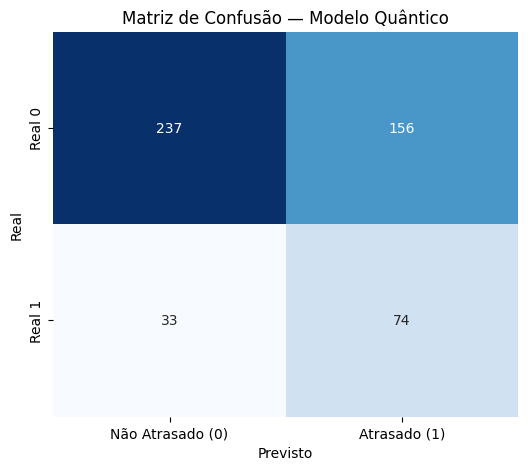

✅ Matriz de confusão criada com sucesso!


In [ ]:
# Recalculando y_pred_bin, tn, fp, fn, tp para garantir que estão atualizados
y_pred_bin = (y_pred >= best_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test_small_eval, y_pred_bin, labels=[0, 1]).ravel()

# Criando a matriz para visualização
cm = np.array([[tn, fp], [fn, tp]])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Atrasado (0)', 'Atrasado (1)'],
            yticklabels=['Real 0', 'Real 1'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão — Modelo Quântico')
plt.show()
print("✅ Matriz de confusão criada com sucesso!")

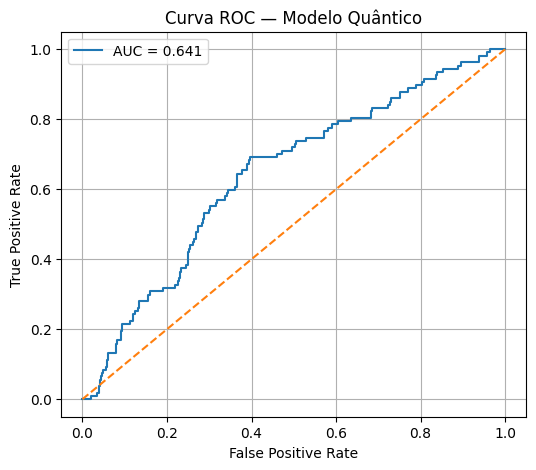

✅ Curva ROC criada com sucesso!


In [ ]:
# Visualizaçao Curva ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC — Modelo Quântico")
plt.legend()
plt.grid(True)
plt.show()
print("✅ Curva ROC criada com sucesso!")

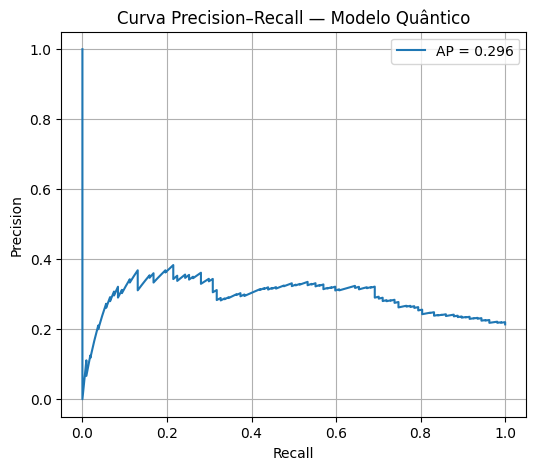

✅ Curva Precision–Recall criada com sucesso!


In [ ]:
#Visualizaçao Curva Precision–Recall
precision_curve, recall_curve, _ = precision_recall_curve(y_test_small_eval, y_pred)
ap = average_precision_score(y_test_small_eval, y_pred)

plt.figure(figsize=(6, 5))
plt.plot(recall_curve, precision_curve, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall — Modelo Quântico")
plt.legend()
plt.grid(True)
plt.show()

print("✅ Curva Precision–Recall criada com sucesso!")

# 1️⃣3️⃣ Conclusão



### 🔍 Principais Observações

O modelo quântico alcançou um ROC-AUC de 0,6410 (64,10%) e uma Acurácia de 0,6220 (62,20%) na subamostra de teste. Embora esses resultados sejam encorajadores para um modelo quântico, treinado com um número reduzido de qubits e dados, eles ainda ficam abaixo do desempenho esperado de modelos clássicos bem estabelecidos para o mesmo problema. Como referência, algoritmos clássicos como Random Forest e Logistic Regression.


O modelo apresentou um Recall relativamente elevado (69,16%), indicando boa capacidade de identificar voos que efetivamente sofrerão atraso. Por outro lado, a Precisão mais baixa (32,17%) revela uma taxa considerável de falsos positivos, ou seja, o modelo tende a prever atrasos que não ocorrem. Esse comportamento é típico em cenários com classes desbalanceadas e reforça a importância de métricas além da acurácia.


📊 Métricas Finais — Modelo Quântico (VQC)
| Métrica   | Valor           |
| --------- | --------------- |
| ROC-AUC   | 0.6410 (64.10%) |
| Accuracy  | 0.6220 (62.20%) |
| Precision | 0.3217 (32.17%) |
| Recall    | 0.6916 (69.16%) |
| F1-Score  | 0.4392 (43.92%) |


A necessidade de trabalhar com subamostras muito reduzidas (300 amostras para treino e 500 para avaliação), além do uso de apenas 4 features, evidencia as limitações severas da simulação quântica em hardware clássico. Mesmo nesse cenário simplificado, o treinamento é computacionalmente custoso e lento, o que limita a escalabilidade do modelo.


A adoção de pesos de classe na função de perda foi fundamental para mitigar o desbalanceamento inerente ao problema (menos voos atrasados do que pontuais). Essa estratégia contribuiu diretamente para o Recall satisfatório da classe minoritária, tornando o modelo mais sensível à detecção de atrasos — um aspecto relevante do ponto de vista operacional.

Em síntese, este estudo evidencia que o Machine Learning Quântico, no estágio atual, é mais adequado para pesquisa e aprendizado, mas representa um caminho promissor para o futuro da computação e da ciência de dados.

---------

### ⏭️ Próximos Passos e Perspectivas Futuras

1. Exploração de Arquiteturas Quânticas: Avaliar diferentes ansatzes e estruturas de circuitos quânticos variacionais mais adequadas a dados tabulares e problemas de classificação.

2. Escalabilidade de Dados e Features: Com a evolução dos simuladores e, principalmente, do hardware quântico, será possível ampliar o número de features e o volume de dados, fator essencial para tornar o QML competitivo.

3. Redução de Custo Computacional: Avaliar técnicas de feature selection e codificações mais eficientes (Data-reuploading) visando aumentar a expressividade do modelo sem elevar o número de qubits ou a profundidade dos circuitos.
